<a href="https://colab.research.google.com/github/apoorvapu/data_science/blob/main/rag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pymupdf requests

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 31.6 MB/s eta 0:00:00


In [2]:
import os
import requests
import fitz  # PyMuPDF

# Sample arXiv paper IDs related to diffusion models
arxiv_ids = [ "2210.05274",  # Equivariant 3D-Conditional Diffusion Models for Molecular Linker Design
             ]

def download_pdf(arxiv_id, output_folder):
    url = f"https://arxiv.org/pdf/{arxiv_id}.pdf"
    pdf_path = os.path.join(output_folder, f"{arxiv_id}.pdf")
    response = requests.get(url)
    with open(pdf_path, "wb") as f:
        f.write(response.content)
    print(f"Downloaded {arxiv_id}")
    return pdf_path

def pdf_to_text(pdf_path, txt_path):
    doc = fitz.open(pdf_path)
    text = ""
    for page in doc:
        text += page.get_text()
    with open(txt_path, "w", encoding="utf-8") as f:
        f.write(text)
    print(f"Converted to text: {txt_path}")


In [3]:
    data_dir = "data"
    os.makedirs(data_dir, exist_ok=True)

    for arxiv_id in arxiv_ids:
        pdf_path = download_pdf(arxiv_id, data_dir)
        txt_path = os.path.join(data_dir, f"{arxiv_id}.txt")
        pdf_to_text(pdf_path, txt_path)

Downloaded 2210.05274
Converted to text: data/2210.05274.txt


In [4]:

def clean_text(text):
    import re

    # Remove URLs
    text = re.sub(r"http\S+|www\.\S+", "", text)

    # Remove LaTeX math expressions
    text = re.sub(r"$.*?$", "", text)

    # Remove repeated words
    text = re.sub(r"\b(\w+)( \1\b)+", r"\1", text)

    # Remove special characters
    text = re.sub(r"[^a-zA-Z0-9.,;:?!\s]", "", text)

    # Pattern for common author name formats
    pattern = r"\b([A-Z][a-z]+(?: [A-Z][a-z]+)*,? (?:[A-Z]\.)?\b(?: and [A-Z][a-z]+(?: [A-Z][a-z]+)*,? (?:[A-Z]\.)?)+|\b(?:et al\.)\b)"
    # Replace any matched author names with an empty string
    text = re.sub(pattern, '', text)

    # Remove excessive whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

def clean_text_remove_references(text):
    # Remove extra newlines and empty lines
    text = "\n".join([line.strip() for line in text.splitlines() if line.strip() != ""])

    # Cut off everything after 'References' or 'Bibliography'
    refs_keywords = ["references", "bibliography"]
    for keyword in refs_keywords:
        idx = text.lower().find(keyword)
        if idx != -1:
            text = text[:idx]  # Keep text before the references section
            break

    # Remove sections related to funding or acknowledgments
    text = re.sub(r".*grant agreement.*|.*funding.*|.*acknowledg(e)?ment.*", "", text, flags=re.IGNORECASE)

    return text




RAG:

<img src="https://huggingface.co/datasets/huggingface/cookbook-images/resolve/main/RAG_workflow.png" height="700">



In [5]:
!pip install -q torch transformers accelerate bitsandbytes langchain sentence-transformers faiss-cpu openpyxl pacmap datasets langchain-community ragatouille

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 25.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 821.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 70.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 7.3 MB/s eta 0:00:00
 

In [6]:
from tqdm.notebook import tqdm
import pandas as pd
from typing import Optional, List, Tuple
import matplotlib.pyplot as plt
import re
pd.set_option(
    "display.max_colwidth", None
)  # This will be helpful when visualizing retriever outputs

In [7]:
from langchain.docstore.document import Document as LangchainDocument

# Read the text file
with open("/content/data/2210.05274.txt", "r", encoding="utf-8") as f:
    text = f.read()

text = clean_text_remove_references(text)
text = clean_text(text)

# Create a list with one LangchainDocument
RAW_KNOWLEDGE_BASE = [
    LangchainDocument(page_content=text, metadata={"source": "*.txt"})
]


In [8]:
print(text)

Preprint EQUIVARIANT 3DCONDITIONAL DIFFUSION MODELS FOR MOLECULAR LINKER DESIGN Ilia Igashov EPFL ilia.igashovepfl.ch Hannes Stark Massachusetts Institute of Technology hstarkmit.edu Clement Vignac EPFL clement.vignacepfl.ch Victor Garcia Satorras Microsoft Research AI4Science victorgarmicrosoft.com Pascal Frossard EPFL pascal.frossardepfl.ch Max Welling Microsoft Research AI4Science maxwellingmicrosoft.com Michael Bronstein University of Oxford michael.bronsteincs.ox.ac.uk Bruno Correia EPFL bruno.correiaepfl.ch ABSTRACT Fragmentbased drug discovery has been an effective paradigm in earlystage drug development. An open challenge in this area is designing linkers between dis connected molecular fragments of interest to obtain chemicallyrelevant candi date drug molecules. In this work, we propose DiffLinker, an E3equivariant 3Dconditional diffusion model for molecular linker design. Given a set of dis connected fragments, our model places missing atoms in between and designs a molecule 

### Load your knowledge base

given a user question, find the most relevant snippets from our knowledge base to answer that question.

How many snippets should we retrieve? This parameter will be named `top_k`.

How long should these snippets be? This is called the `chunk size`.

In [9]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

# We use a hierarchical list of separators specifically tailored for splitting Markdown documents
# This list is taken from LangChain's MarkdownTextSplitter class
SEPARATORS = [
    "\n",
    " ",
]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # The maximum number of characters in a chunk: we selected this value arbitrarily
    chunk_overlap=100,  # The number of characters to overlap between chunks
    add_start_index=True,  # If `True`, includes chunk's start index in metadata
    strip_whitespace=True,  # If `True`, strips whitespace from the start and end of every document
    separators=SEPARATORS,
)

docs_processed = []
for doc in RAW_KNOWLEDGE_BASE:
    docs_processed += text_splitter.split_documents([doc])

In [10]:
docs_processed[0]

Document(metadata={'source': '*.txt', 'start_index': 0}, page_content='Preprint EQUIVARIANT 3DCONDITIONAL DIFFUSION MODELS FOR MOLECULAR LINKER DESIGN Ilia Igashov EPFL ilia.igashovepfl.ch Hannes Stark Massachusetts Institute of Technology hstarkmit.edu Clement Vignac EPFL clement.vignacepfl.ch Victor Garcia Satorras Microsoft Research AI4Science victorgarmicrosoft.com Pascal Frossard EPFL pascal.frossardepfl.ch Max Welling Microsoft Research AI4Science maxwellingmicrosoft.com Michael Bronstein University of Oxford michael.bronsteincs.ox.ac.uk Bruno Correia EPFL bruno.correiaepfl.ch ABSTRACT Fragmentbased drug discovery has been an effective paradigm in earlystage drug development. An open challenge in this area is designing linkers between dis connected molecular fragments of interest to obtain chemicallyrelevant candi date drug molecules. In this work, we propose DiffLinker, an E3equivariant 3Dconditional diffusion model for molecular linker design. Given a set of dis connected fragm

In [11]:
docs_processed[10]

Document(metadata={'source': '*.txt', 'start_index': 8999}, page_content='molecular graph. Since they have access to the connectivity information, they can compute torsion angles between atoms and optimize them Jing et al., 2022. Equivariant Diffusion Model EDM Hoogeboom et al., 2022 generates 3D molecules from scratch and is able to be conditioned on the predened scalar prop erties. Another diffusion model has been recently proposed for designing protein scaffolds given protein motifs Trippe et al., 2022. Having the conditional sampling procedure, this model is how ever trained in an unconditional setup. Finally, Luo et al. 2022 proposed a model for antibody design which combines discrete diffusion for the molecular graphs and continuous diffusion on the 3D coordinates. The conditioning mechanism proposed in this work is the closest to ours, but their model is targeted at generating chains of amino acids rather than atomic point clouds. 3 PRELIMINARIES 3.1 DIFFUSION MODELS Diffusion m

We also have to keep in mind that when embedding documents, we will use an embedding model that accepts a certain maximum sequence length `max_seq_length`.

So we should make sure that our chunk sizes are below this limit because any longer chunk will be truncated before processing, thus losing relevancy.

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/68.1k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/66.7M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Model's maximum sequence length: 512


  0%|          | 0/39 [00:00<?, ?it/s]

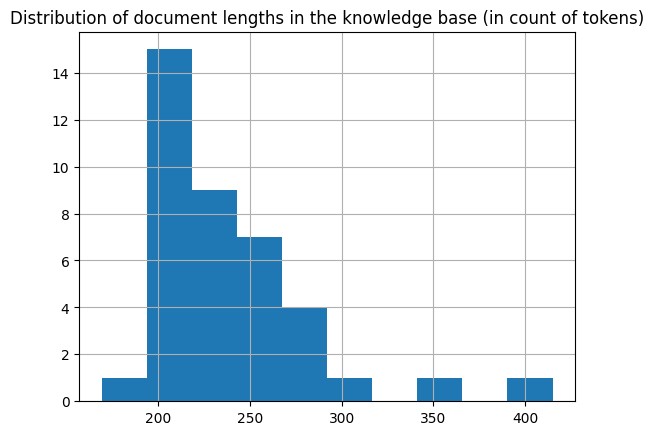

In [12]:
from sentence_transformers import SentenceTransformer

# To get the value of the max sequence_length, we will query the underlying `SentenceTransformer` object used in the RecursiveCharacterTextSplitter
print(
    f"Model's maximum sequence length: {SentenceTransformer('thenlper/gte-small').max_seq_length}"
)

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("thenlper/gte-small")
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]

# Plot the distribution of document lengths, counted as the number of tokens
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

👀 As you can see, __the chunk lengths are not aligned with our limit of 512 tokens__, and some documents are above the limit, thus some part of them will be lost in truncation!
 - So we should change the `RecursiveCharacterTextSplitter` class to count length in number of tokens instead of number of characters.
 - Then we can choose a specific chunk size, here we would choose a lower threshold than 512:
    - Smaller documents could allow the split to focus more on specific ideas.
    - But too small chunks would split sentences in half, thus losing meaning again: the proper tuning is a matter of balance.

  0%|          | 0/18 [00:00<?, ?it/s]

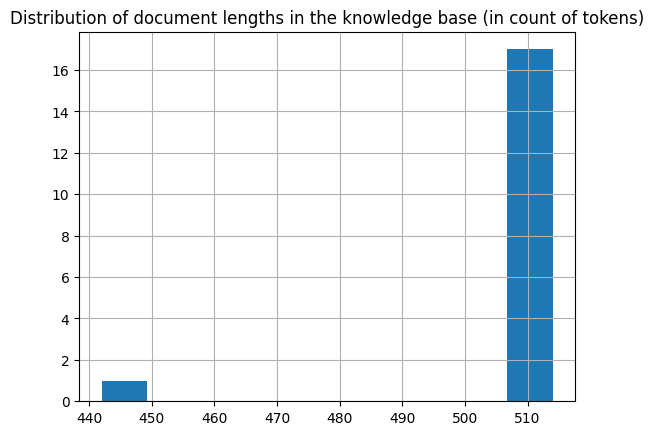

In [13]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from transformers import AutoTokenizer

EMBEDDING_MODEL_NAME = "thenlper/gte-small"


def split_documents(
    chunk_size: int,
    knowledge_base: List[LangchainDocument],
    tokenizer_name: Optional[str] = EMBEDDING_MODEL_NAME,
) -> List[LangchainDocument]:
    """
    Split documents into chunks of maximum size `chunk_size` tokens and return a list of documents.
    """
    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        AutoTokenizer.from_pretrained(tokenizer_name),
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        add_start_index=True,
        strip_whitespace=True,
        separators=SEPARATORS,
    )

    docs_processed = []
    for doc in knowledge_base:
        docs_processed += text_splitter.split_documents([doc])

    # Remove duplicates
    unique_texts = {}
    docs_processed_unique = []
    for doc in docs_processed:
        if doc.page_content not in unique_texts:
            unique_texts[doc.page_content] = True
            docs_processed_unique.append(doc)

    return docs_processed_unique


docs_processed = split_documents(
    512,  # We choose a chunk size adapted to our model
    RAW_KNOWLEDGE_BASE,
    tokenizer_name=EMBEDDING_MODEL_NAME,
)

# Let's visualize the chunk sizes we would have in tokens from a common model
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

➡️ Now the chunk length distribution looks better!

### 1.2 Building the vector database

#### How does retrieval work?

Once the chunks are all embedded, we store them in a vector database. When the user types in a query, it gets embedded by the same model previously used, and a similarity search returns the closest documents from the vector database.

The technical challenge is thus, given a query vector, to quickly find the nearest neighbors of this vector in the vector database. To do this, we need to choose two things: a distance, and a search algorithm to find the nearest neighbors quickly within a database of thousands of records.

##### Nearest Neighbor search algorithm

There are plentiful choices for the nearest neighbor search algorithm: we go with Facebook's [FAISS](https://github.com/facebookresearch/faiss) since FAISS is performant enough for most use cases, and it is well known and thus widely implemented.

##### Distances

- **Cosine similarity** computes the similarity between two vectors as the cosinus of their relative angle: it allows us to compare vector directions regardless of their magnitude. Using it requires normalizing all vectors, to rescale them into unit norm.
- **Dot product** takes into account magnitude, with the sometimes undesirable effect that increasing a vector's length will make it more similar to all others.
- **Euclidean distance** is the distance between the ends of vectors.

cosine similarity: choose this distance, and we set it up both in the Embedding model, and in the `distance_strategy` argument of our FAISS index. With cosine similarity, we have to normalize our embeddings.

In [14]:
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy

embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},  # Set `True` for cosine similarity
)

KNOWLEDGE_VECTOR_DATABASE = FAISS.from_documents(
    docs_processed, embedding_model, distance_strategy=DistanceStrategy.COSINE
)

<ipython-input-14-86d3e6721df3>:5: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(


👀 To visualize the search for the closest documents, let's project our embeddings from 384 dimensions down to 2 dimensions using PaCMAP.

In [15]:
# Embed a user query in the same space
user_query = "What is diffusion?"
query_vector = embedding_model.embed_query(user_query)

In [16]:
import pacmap
import numpy as np
import plotly.express as px

embedding_projector = pacmap.PaCMAP(
    n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0, random_state=1
)

embeddings_2d = [
    list(KNOWLEDGE_VECTOR_DATABASE.index.reconstruct_n(idx, 1)[0])
    for idx in range(len(docs_processed))
] + [query_vector]

# Fit the data (the index of transformed data corresponds to the index of the original data)
documents_projected = embedding_projector.fit_transform(
    np.array(embeddings_2d), init="pca"
)

In [17]:
print(f"\nStarting retrieval for {user_query=}...")
retrieved_docs = KNOWLEDGE_VECTOR_DATABASE.similarity_search(query=user_query, k=5)
print(
    "\n==================================Top document=================================="
)
print(retrieved_docs[0].page_content)
print("==================================Metadata==================================")
print(retrieved_docs[0].metadata)


Starting retrieval for user_query='What is diffusion?'...

==================================Top document==================================
pairs of fragments and cannot be easily extended to larger sets of fragments. Outside of the linker design problem, several recent works proposed denoising diffusion models for molecular data in 3D. Conformer generation methods GeoDiff Xu et al., 2022 and ConfGF Shi et al., 2021 condition the model on the adjacency matrix of the molecular graph. Since they have access to the connectivity information, they can compute torsion angles between atoms and optimize them Jing et al., 2022. Equivariant Diffusion Model EDM Hoogeboom et al., 2022 generates 3D molecules from scratch and is able to be conditioned on the predened scalar prop erties. Another diffusion model has been recently proposed for designing protein scaffolds given protein motifs Trippe et al., 2022. Having the conditional sampling procedure, this model is how ever trained in an unconditio

# 2. Reader - LLM 💬

In this part, the __LLM Reader reads the retrieved context to formulate its answer.__

There are substeps that can all be tuned:
1. The content of the retrieved documents is aggregated together into the "context", with many processing options like _prompt compression_.
2. The context and the user query are aggregated into a prompt and then given to the LLM to generate its answer.

### 2.1. Reader model

The choice of a reader model is important in a few aspects:
- the reader model's `max_seq_length` must accommodate our prompt, which includes the context output by the retriever call: the context consists of 5 documents of 512 tokens each, so we aim for a context length of 4k tokens at least.
- the reader model

For this example, we chose [`HuggingFaceH4/zephyr-7b-beta`](https://huggingface.co/HuggingFaceH4/zephyr-7b-beta), a small but powerful model.

With many models being released every week, you may want to substitute this model to the latest and greatest. The best way to keep track of open source LLMs is to check the [Open-source LLM leaderboard](https://huggingface.co/spaces/HuggingFaceH4/open_llm_leaderboard).

To make inference faster, we will load the quantized version of the model:

In [18]:
from transformers import pipeline
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

READER_MODEL_NAME = "HuggingFaceH4/zephyr-7b-beta"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)
model = AutoModelForCausalLM.from_pretrained(
    READER_MODEL_NAME, quantization_config=bnb_config
)
tokenizer = AutoTokenizer.from_pretrained(READER_MODEL_NAME)

READER_LLM = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    do_sample=True,
    temperature=0.2,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=500,
)

config.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not in

model-00003-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00008-of-00008.safetensors:   0%|          | 0.00/816M [00:00<?, ?B/s]

model-00002-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00001-of-00008.safetensors:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

model-00004-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00006-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00007-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00005-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

Device set to use cuda:0


In [19]:
READER_LLM("What is diffusion? Answer:")

[{'generated_text': ' Diffusion is the movement of molecules from a region of higher concentration to a region of lower concentration. This process occurs spontaneously and does not require any external energy source.\n\nDiffusion is driven by the random motion of particles, known as Brownian motion. The greater the concentration gradient (the difference in concentration between two regions), the faster the rate of diffusion. Factors that affect the rate of diffusion include temperature, particle size, and solubility.\n\nIn living organisms, diffusion plays a critical role in the transport of nutrients, waste products, and other substances across cell membranes. It also helps to maintain a steady state of ions and molecules within cells and tissues.\n\nExamples of diffusion in biological systems include the transport of oxygen from the lungs to the bloodstream, the movement of glucose from the blood into muscle cells during exercise, and the exchange of gases between the alveoli in the

### 2.2. Prompt

The RAG prompt template below is what we will feed to the Reader LLM: it is important to have it formatted in the Reader LLM's chat template.

We give it our context and the user's question.

In [20]:
prompt_in_chat_format = [
    {
        "role": "system",
        "content": """Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.""",
    },
    {
        "role": "user",
        "content": """Context:
{context}
---
Now here is the question you need to answer.

Question: {question}""",
    },
]
RAG_PROMPT_TEMPLATE = tokenizer.apply_chat_template(
    prompt_in_chat_format, tokenize=False, add_generation_prompt=True
)
print(RAG_PROMPT_TEMPLATE)

<|system|>
Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.</s>
<|user|>
Context:
{context}
---
Now here is the question you need to answer.

Question: {question}</s>
<|assistant|>



Let's test our Reader on our previously retrieved documents!

In [21]:
retrieved_docs_text = [
    doc.page_content for doc in retrieved_docs
]  # We only need the text of the documents
context = "\nExtracted documents:\n"
context += "".join(
    [f"Document {str(i)}:::\n" + doc for i, doc in enumerate(retrieved_docs_text)]
)

final_prompt = RAG_PROMPT_TEMPLATE.format(
    question="Can you explain the main result?", context=context
)

# Redact an answer
answer = READER_LLM(final_prompt)[0]["generated_text"]
print(answer)

The main conclusion of this research is the introduction of DiffLinker, an E3equivariant 3Dconditional diffusion model for molecular linker design. DiffLinker is able to connect an arbitrary number of disconnected molecular fragments, unlike previous approaches that only connect pairs of fragments. It automatically determines the number of atoms in the linker and its attachment points to the input fragments, making it more versatile than existing methods. The authors demonstrate that DiffLinker outperforms other methods on standard datasets, generating more diverse and synthetically accessible molecules, and they experimentally test DiffLinker in real-world applications, successfully generating valid linkers conditioned on target protein pockets. Overall, DiffLinker represents a significant advancement in fragment-based drug discovery, reducing the size of the vast space of pharmacologically relevant molecules and providing a cheaper and more efficient alternative to experimental high-

In [22]:
final_prompt = RAG_PROMPT_TEMPLATE.format(
    question="What are the main themes discussed in this work?", context=context
)

# Redact an answer
answer = READER_LLM(final_prompt)[0]["generated_text"]
print(answer)

The main theme of this text is the introduction and explanation of DiffLinker, an E3equivariant 3Dconditional diffusion model for molecular linker design. The text discusses the challenges of fragment-based drug discovery, specifically the difficulty of designing linkers between disconnected molecular fragments, and proposes DiffLinker as a solution. The paper explains the requirements and strategies for implementing DiffLinker, including equivariance, sampling, and conditioning on protein pockets. The paper also provides background information on diffusion models and molecule representation. Overall, the text focuses on the development and application of DiffLinker for molecular linker design.


In [23]:
final_prompt = RAG_PROMPT_TEMPLATE.format(
    question="How is this work related to other similar journal papers? What similar work precedes it?", context=context
)

# Redact an answer
answer = READER_LLM(final_prompt)[0]["generated_text"]
print(answer)

The passage provides a comparison of the proposed DiffLinker method with other similar works in the field of molecular linker design. It mentions some recent works that proposed denoising diffusion models for molecular data in 3D, such as GeoDiff Xu et al., 2022, ConfGF Shi et al., 2021, and EDM Hoogeboom et al., 2022. However, these methods are limited to connecting pairs of fragments and cannot handle an arbitrary number of fragments. DiffLinker, on the other hand, can link an arbitrary number of fragments and automatically determine the number of atoms in the linker and its attachment points to the input fragments. The passage also mentions a few other diffusion models for molecular generation, such as Luo et al., 2022, which combines discrete diffusion for molecular graphs and continuous diffusion on the 3D coordinates, and Trippe et al., 2022, which generates protein scaffolds given protein motifs. However, these methods are trained in an unconditional setup and are not specifical

In [24]:
final_prompt = RAG_PROMPT_TEMPLATE.format(
    question="Can you give a literature review of papers with similar conclusions?", context=context
)

# Redact an answer
answer = READER_LLM(final_prompt)[0]["generated_text"]
print(answer)

Based on the context provided, there are several papers discussed in the text that address similar topics related to molecular modeling and diffusion models. Here is a brief literature review:

1. "Pairs of fragments and cannot be easily extended to larger sets of fragments" (Document 0) refers to the limitations of traditional linker design methods that can only connect pairs of fragments. This issue has been addressed in several papers, such as:
   - "Fragment-based Drug Design: A Review" by Erlanson et al. (2016), which discusses the advantages and limitations of FBDD and highlights the importance of developing methods for connecting multiple fragments.
   - "Designing Multiple Linkers in One Step" by Zhang et al. (2019), which proposes a deep learning framework called MultiLinkerNet for simultaneously predicting multiple linkers between two fragments.
   - "Deep Learning Methods for De Novo Molecular Design" by Chen et al. (2021), which reviews recent advances in deep learning tech

In [25]:
final_prompt = RAG_PROMPT_TEMPLATE.format(
    question="What is the speciality of the diffusion model discussed here? How has the method been applied in this work?", context=context
)

# Redact an answer
answer = READER_LLM(final_prompt)[0]["generated_text"]
print(answer)

The specialty of the diffusion model discussed in this work is its ability to generate molecular linkers, which are the connecting parts between disconnected molecular fragments, in a three-dimensional (3D) context while being conditioned on both the fragments and their surrounding protein pockets. This method, called DiffLinker, is an E3equivariant 3Dconditional diffusion model that can handle an arbitrary number of fragments and automatically determines the number of atoms in the linker and its attachment points to the input fragments. The model has demonstrated superior performance compared to other methods on standard datasets and has been successfully applied in real-world applications, including generating valid linkers conditioned on target protein pockets.


In [26]:
final_prompt = RAG_PROMPT_TEMPLATE.format(
    question="What are the limitations of this work?", context=context
)

# Redact an answer
answer = READER_LLM(final_prompt)[0]["generated_text"]
print(answer)

The limitations of this work, as mentioned in the context, include:

1. The method is currently limited to linker design between disconnected fragments, whereas previous approaches could only connect pairs of fragments.
2. The method assumes a fixed number of atoms in the linker, whereas other methods may allow for variable linker lengths.
3. The method requires a 3D context, such as input fragments or protein pocket atoms, which may not always be available.
4. The effectiveness of the method in real-world applications beyond the standard datasets is not extensively tested.

Overall, while the proposed DiffLinker method shows promising results for linker design, further research is needed to address these limitations and improve its applicability in various scenarios.


In [28]:
final_prompt = RAG_PROMPT_TEMPLATE.format(
    question="Can you compare this work with some other papers that are similar but not discussed in this work?", context=context
)

# Redact an answer
answer = READER_LLM(final_prompt)[0]["generated_text"]
print(answer)

The context provided does not mention any specific papers for comparison. However, the authors briefly discuss some related works in the introduction and preliminaries sections. These include:

- GeoDiff Xu et al., 2022: This paper proposes a conformer generation method for molecular data in 3D, conditioned on the adjacency matrix of the molecular graph. It can compute torsion angles between atoms and optimize them.

- ConfGF Shi et al., 2021: Similar to GeoDiff, this paper proposes a conformer generation method for molecular data in 3D, conditioned on the molecular graph. It can also generate 3D molecules from scratch, but does not explicitly mention the ability to compute torsion angles or optimize them.

- Equivariant Diffusion Model (EDM) Hoogeboom et al., 2022: This paper presents a diffusion model for generating 3D molecules from scratch, which is equivariant to the Euclidean group E3. It can also be conditioned on predefined scalar properties, such as logP or solubility.

- Trip